# ICPR 2024 Competition on Multilingual Claim-Span Identification

## Installing Dependencies

In [ ]:
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn

### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

### Loading Datasets

In [ ]:
# Training English and Hindi datasets
train_data = pd.read_json("/content/drive/MyDrive/Multilingual Datasets/ML Data/train_en_hi_encoded_labels.json")


# Validation English and Hindi datasets
val_data = pd.read_json("/content/drive/MyDrive/Multilingual Datasets/ML Data/val_en_hi_encoded_labels.json")

In [ ]:
train_data.head()

,claims,text_tokens,labels
0,0,#vaers 17y #pfizer #covidvaccine #suicide atte...,not_claim
1,1,weve truly come a long way from december and j...,claim
2,1,fuck that its not faux outrage inject them wit...,claim
3,1,@u55750420 which makes no sense the vaccine ca...,claim
4,1,fact or fiction you decide the upcoming corona...,claim


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12068 entries, 0 to 12067
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   claims       12068 non-null  int64 
 1   text_tokens  12068 non-null  object
 2   labels       12068 non-null  object
dtypes: int64(1), object(2)
memory usage: 283.0+ KB


In [ ]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   claims       999 non-null    int64 
 1   text_tokens  999 non-null    object
 2   labels       999 non-null    object
dtypes: int64(1), object(2)
memory usage: 23.5+ KB


### Feature Extraction

In [ ]:
"""
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline


tfidf = TfidfTransformer()
clf = CountVectorizer()

# Training data
x =  clf.fit_transform(train_data['text_tokens'])
y= train_data['claims']

tf_transformer = TfidfTransformer(use_idf=True).fit(x)
X = tf_transformer.transform(x)

# Validation data
x_val = clf.fit_transform(val_data['text_tokens'])
y_val = val_data['claims']

val_tf_transformer = TfidfTransformer(use_idf=True).fit(x_val)
X_val_data = val_tf_transformer.transform(x_val)

print("----Training Data------")
print(X.shape)
print(y.shape)

print("\n----Validation Data------")
print(X_val_data.shape)
print(y_val.shape)
"""

'\nfrom sklearn.feature_extraction.text import CountVectorizer\nfrom sklearn.feature_extraction.text import TfidfTransformer\nfrom sklearn.pipeline import Pipeline\n\n\ntfidf = TfidfTransformer()\nclf = CountVectorizer()\n\n# Training data\nx =  clf.fit_transform(train_data[\'text_tokens\'])\ny= train_data[\'claims\']\n\ntf_transformer = TfidfTransformer(use_idf=True).fit(x)\nX = tf_transformer.transform(x)\n\n# Validation data\nx_val = clf.fit_transform(val_data[\'text_tokens\'])\ny_val = val_data[\'claims\']\n\nval_tf_transformer = TfidfTransformer(use_idf=True).fit(x_val)\nX_val_data = val_tf_transformer.transform(x_val)\n\nprint("----Training Data------")\nprint(X.shape)\nprint(y.shape)\n\nprint("\n----Validation Data------")\nprint(X_val_data.shape)\nprint(y_val.shape)\n'

In [ ]:
"""
# Splitting the dataset into the Training set and validation Set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_val_data, y_val, test_size = 0.25, random_state = 42)
"""

'\n# Splitting the dataset into the Training set and validation Set\nfrom sklearn.model_selection import train_test_split\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)\nX_train, X_val, y_train, y_val = train_test_split(X_val_data, y_val, test_size = 0.25, random_state = 42)\n'

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Define pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=True))
])

# Apply pipeline on training data
X = pipeline.fit_transform(train_data['text_tokens'])
y = train_data['claims']

# Apply same pipeline on validation data
X_val = pipeline.transform(val_data['text_tokens'])
y_val = val_data['claims']

print("----Training Data------")
print(X.shape)
print(y.shape)

print("\n----Validation Data------")
print(X_val.shape)
print(y_val.shape)

----Training Data------
(12068, 24811)
(12068,)

----Validation Data------
(999, 24811)
(999,)


In [ ]:
# Splitting the dataset into the Training set and testing Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [ ]:
y_train.value_counts()

claims
1    8830
0    2031
Name: count, dtype: int64

__After checking the training set, there are imbalance of data and it may cause a bias in training the model. Oversampling using `SMOTE` will be used to balance the train dataset.__

### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Check the initial class distribution
print("Initial class distribution:", Counter(y_train))

Initial class distribution: Counter({1: 8830, 0: 2031})


In [ ]:
# Initialize SMOTE with a strategy to balance all classes equally
smote = SMOTE(sampling_strategy='auto', random_state=42)


# Apply SMOTE
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
# Check the class distribution after SMOTE
print("Resampled class distribution:", Counter(y_train_res))

Resampled class distribution: Counter({1: 8830, 0: 8830})


__Now, the training set is balanced and ready to be feed into the ML models.__

### Model Training & Development

### Decision Trees Classifier

In [ ]:
from sklearn.metrics import jaccard_score, f1_score
from sklearn.svm import SVC

In [ ]:
# Decision Trees

from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree

Tree_clf = DecisionTreeClassifier(criterion="entropy", max_depth=42, random_state=42)  #80
Tree_clf.fit(X_train, y_train)

tree_pred = Tree_clf.predict(X_val)

In [ ]:
claims = ['not_claim', 'claim']

print('Classification Report for Decision Trees:\n',classification_report(y_val, tree_pred, target_names=claims))

Classification Report for Decision Trees:
               precision    recall  f1-score   support

   not_claim       0.41      0.26      0.32       183
       claim       0.85      0.92      0.88       816

    accuracy                           0.80       999
   macro avg       0.63      0.59      0.60       999
weighted avg       0.77      0.80      0.78       999



In [ ]:
# Calculating Jaccard similarity score
jaccard_score_value = jaccard_score(y_val, tree_pred)

# Calculating Macro-F1 score
macro_f1_score = f1_score(y_val, tree_pred, average='macro')

print("Jaccard score:", jaccard_score_value)
print("Macro-F1 score:", macro_f1_score)

Jaccard score: 0.786540483701367
Macro-F1 score: 0.600794092925014


### Logistic Regression Model

In [ ]:
#Logistic Regression Model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# train a Logistic Regression Model
LR_clf = LogisticRegression(max_iter = 1000) #83
LR_clf.fit(X_train, y_train)

# evaluate the classifier on the test set
LR_pred = LR_clf.predict(X_val)

In [ ]:
print('Classification Report for Logistic Regression :\n',classification_report(y_val, LR_pred, target_names=claims))

Classification Report for Logistic Regression :
               precision    recall  f1-score   support

   not_claim       0.76      0.16      0.26       183
       claim       0.84      0.99      0.91       816

    accuracy                           0.84       999
   macro avg       0.80      0.57      0.59       999
weighted avg       0.83      0.84      0.79       999



In [ ]:
# Calculating Jaccard similarity score
jaccard_score_value = jaccard_score(y_val, LR_pred)

# Calculating Macro-F1 score
macro_f1_score = f1_score(y_val, LR_pred, average='macro')

print("Jaccard score:", jaccard_score_value)
print("Macro-F1 score:", macro_f1_score)

Jaccard score: 0.831958762886598
Macro-F1 score: 0.5853579040377677


### SVM (Support Vector Machines)

In [ ]:
# SVM (Support Vector Machines)

from sklearn import svm

SV_clf = svm.SVC(kernel='rbf')  #83
SV_clf.fit(X_train, y_train)

svm_pred = SV_clf.predict(X_val)

In [ ]:
print('Classification Report for Support Vector Machines:\n',classification_report(y_val, svm_pred, target_names=claims))

Classification Report for Support Vector Machines:
               precision    recall  f1-score   support

   not_claim       0.74      0.14      0.24       183
       claim       0.84      0.99      0.91       816

    accuracy                           0.83       999
   macro avg       0.79      0.57      0.57       999
weighted avg       0.82      0.83      0.78       999



In [ ]:
# Calculating Jaccard similarity score
jaccard_score_value = jaccard_score(y_val, svm_pred)

# Calculating Macro-F1 score
macro_f1_score = f1_score(y_val, svm_pred, average='macro')

print("Jaccard score:", jaccard_score_value)
print("Macro-F1 score:", macro_f1_score)

Jaccard score: 0.829393627954779
Macro-F1 score: 0.5726368415627254


### RandomForest Classifier

In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

rf_pred = rf_clf.predict(X_val)

In [ ]:
print('Classification Report for Random Forest:\n',classification_report(y_val, rf_pred, target_names=claims))

Classification Report for Random Forest:
               precision    recall  f1-score   support

   not_claim       0.77      0.20      0.32       183
       claim       0.85      0.99      0.91       816

    accuracy                           0.84       999
   macro avg       0.81      0.59      0.62       999
weighted avg       0.83      0.84      0.80       999



In [ ]:
# Calculating Jaccard similarity score
jaccard_score_value = jaccard_score(y_val, rf_pred)

# Calculating Macro-F1 score
macro_f1_score = f1_score(y_val, rf_pred, average='macro')

print("Jaccard score:", jaccard_score_value)
print("Macro-F1 score:", macro_f1_score)

Jaccard score: 0.8367983367983368
Macro-F1 score: 0.6157475800939298


### Multinomial Naive Bayes Classifier algorithm

In [ ]:
from sklearn.naive_bayes import MultinomialNB

MNB_clf = MultinomialNB()
MNB_clf.fit(X_train, y_train)
MNB_pred = MNB_clf.predict(X_val)

In [ ]:
print('Classification Report for Multinomial Naive Bayes:\n',classification_report(y_val, MNB_pred, target_names=claims, zero_division=0))

Classification Report for Multinomial Naive Bayes:
               precision    recall  f1-score   support

   not_claim       0.00      0.00      0.00       183
       claim       0.82      1.00      0.90       816

    accuracy                           0.82       999
   macro avg       0.41      0.50      0.45       999
weighted avg       0.67      0.82      0.73       999



In [ ]:
# Calculating Jaccard similarity score
jaccard_score_value = jaccard_score(y_val, MNB_pred)

# Calculating Macro-F1 score
macro_f1_score = f1_score(y_val, MNB_pred, average='macro')

print("Jaccard score:", jaccard_score_value)
print("Macro-F1 score:", macro_f1_score)

Jaccard score: 0.8168168168168168
Macro-F1 score: 0.44958677685950416


### XGBoost Classifier algorithm

In [ ]:
from xgboost import XGBClassifier

xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)
xgboost_pred = xgboost.predict(X_val)

In [ ]:
print('Classification Report for XGBoost Classifier:\n',classification_report(y_val, xgboost_pred, target_names=claims))

Classification Report for XGBoost Classifier:
               precision    recall  f1-score   support

   not_claim       0.65      0.25      0.36       183
       claim       0.85      0.97      0.91       816

    accuracy                           0.84       999
   macro avg       0.75      0.61      0.63       999
weighted avg       0.82      0.84      0.81       999



In [ ]:
# Calculating Jaccard similarity score
jaccard_score_value = jaccard_score(y_val, xgboost_pred)

# Calculating Macro-F1 score
macro_f1_score = f1_score(y_val, xgboost_pred, average='macro')

print("Jaccard score:", jaccard_score_value)
print("Macro-F1 score:", macro_f1_score)

Jaccard score: 0.8301886792452831
Macro-F1 score: 0.632179675994109


## Confusion Matrix for Different Models

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels_dict, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks([0.5 + i for i in range(len(labels_dict))], [labels_dict[i] for i in labels_dict], rotation=45)
    plt.yticks([0.5 + i for i in range(len(labels_dict))], [labels_dict[i] for i in labels_dict])

    plt.title(title)
    plt.show()

label_dict = {
    0: 'not_claim',
    1: 'claim',
}

### Decision Trees Classifier

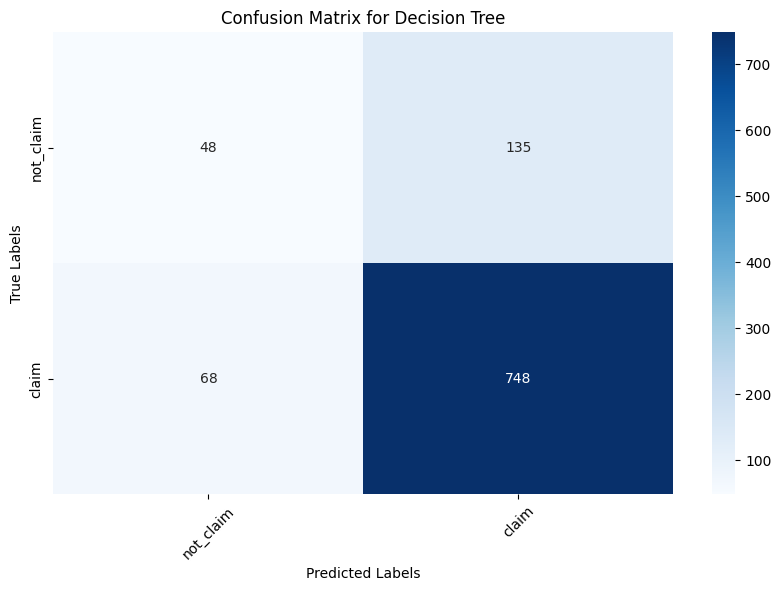

In [ ]:
plot_confusion_matrix(y_val, tree_pred, label_dict, title='Confusion Matrix for Decision Tree')

### Logistic Regression Model

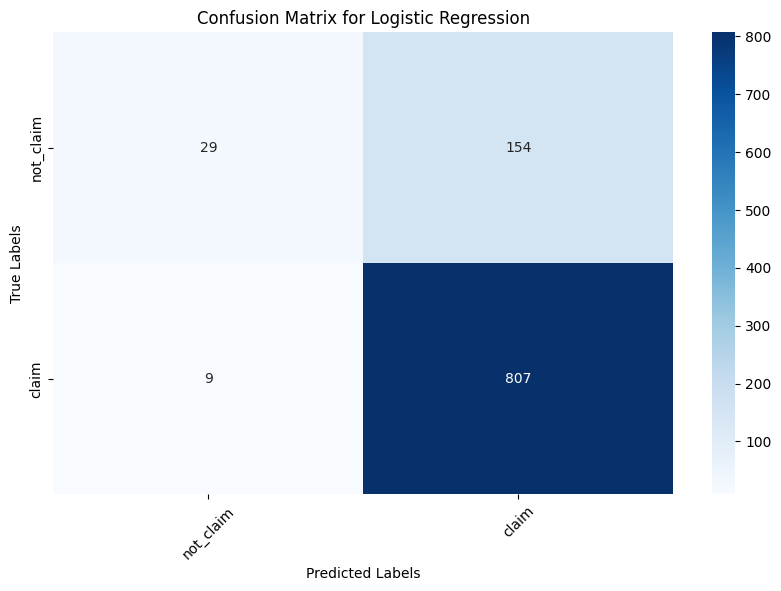

In [ ]:
plot_confusion_matrix(y_val, LR_pred, label_dict, title='Confusion Matrix for Logistic Regression')

### Support Vector Machines Model

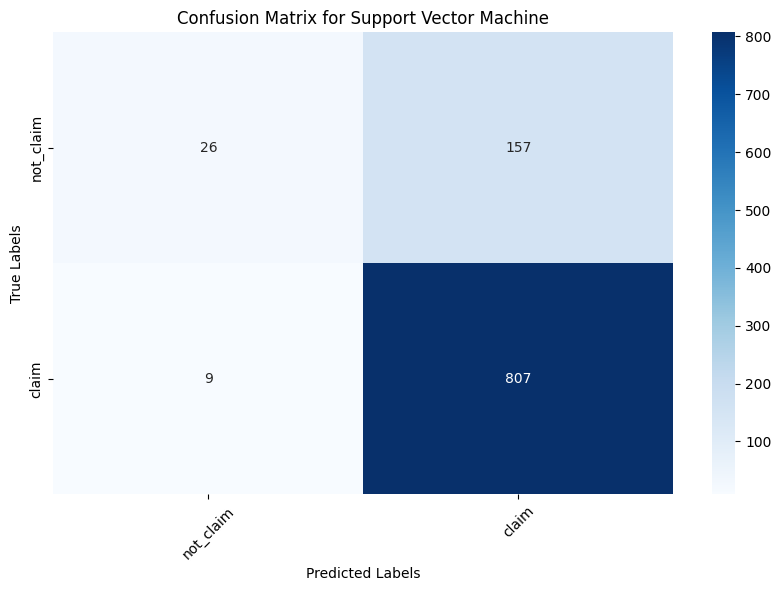

In [ ]:
plot_confusion_matrix(y_val, svm_pred, label_dict, title='Confusion Matrix for Support Vector Machine')

### RandomForest Classifier

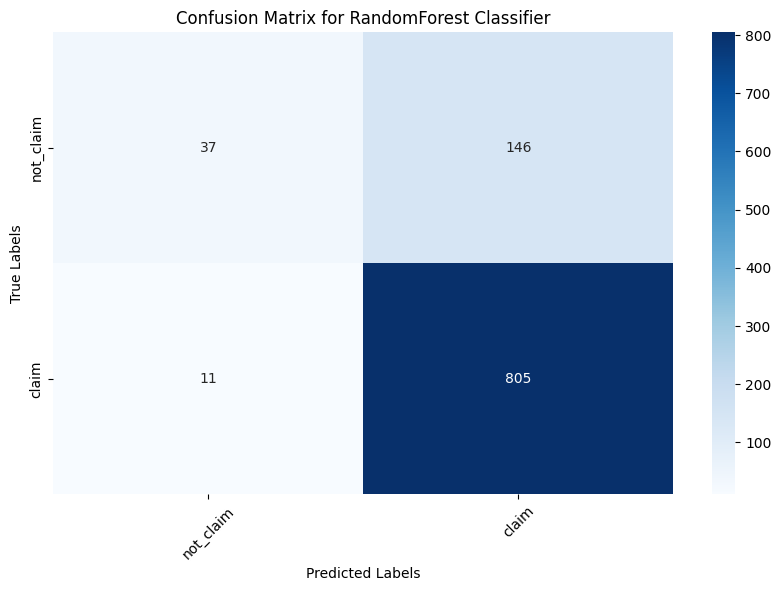

In [ ]:
plot_confusion_matrix(y_val, rf_pred, label_dict, title='Confusion Matrix for RandomForest Classifier')

### Multinomial Naive Bayes Classifier

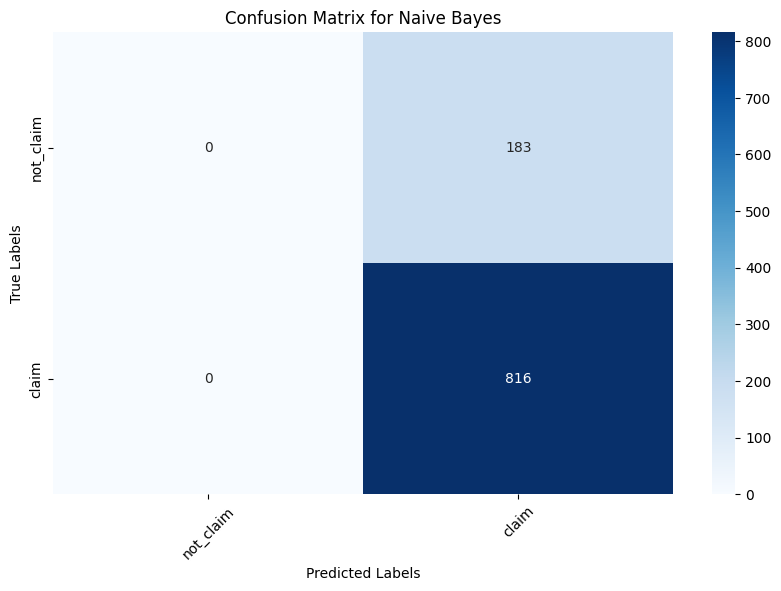

In [ ]:
plot_confusion_matrix(y_val, MNB_pred, label_dict, title='Confusion Matrix for Naive Bayes')

### XGBoost Classifier

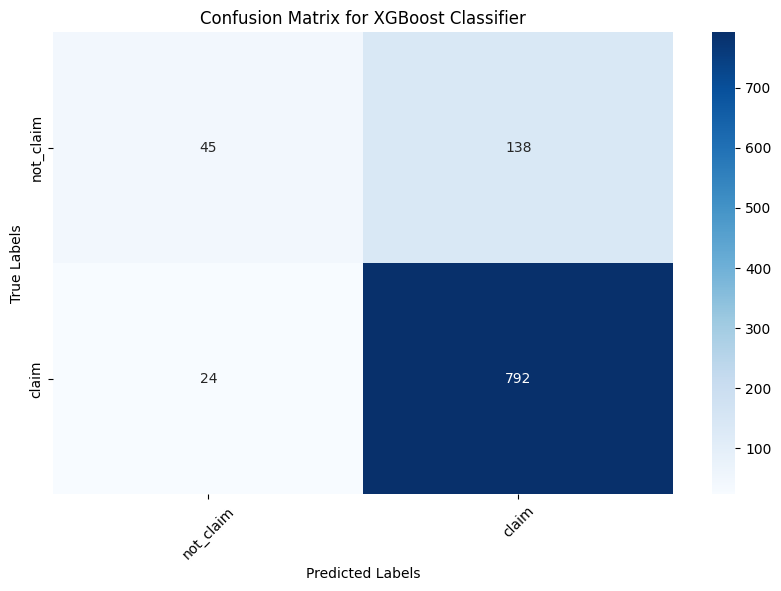

In [ ]:
plot_confusion_matrix(y_val, xgboost_pred, label_dict, title='Confusion Matrix for XGBoost Classifier')

## Precision-Recall Curve for the trained models

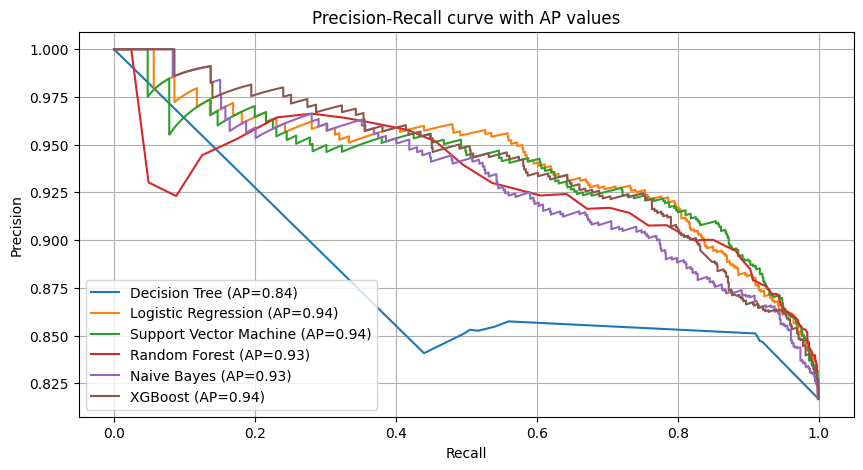

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Ensure that the classifiers are trained and available
classifiers = {
    "Decision Tree": Tree_clf,
    "Logistic Regression": LR_clf,
    "Support Vector Machine": SV_clf,
    "Random Forest": rf_clf,
    "Naive Bayes": MNB_clf,
    "XGBoost": xgboost
}

# Initialize the plot
plt.figure(figsize=(10, 5))

for name, clf in classifiers.items():
    if hasattr(clf, "predict_proba"):
        y_scores = clf.predict_proba(X_val)[:, 1]
    else:
        y_scores = clf.decision_function(X_val)

    precision, recall, _ = precision_recall_curve(y_val, y_scores)
    ap = average_precision_score(y_val, y_scores)  # Calculate Average Precision (AP)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.2f})")

# Add legend and title
plt.legend(loc='lower left')
plt.title('Precision-Recall curve with AP values')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

The Precision-Recall (PR) curve is a plot of the precision and recall pairs for different thresholds used in binary classification problems. Here's an explanation of the components and interpretation of the curve:

1. **Precision**: Precision is the ratio of correctly predicted positive observations to the total predicted positives. It is calculated as TP / (TP + FP), where TP is the number of true positives and FP is the number of false positives. Precision emphasizes the quality of the positive predictions.

2. **Recall (Sensitivity)**: Recall, also known as sensitivity or true positive rate (TPR), is the ratio of correctly predicted positive observations to all actual positives. It is calculated as TP / (TP + FN), where FN is the number of false negatives. Recall emphasizes the coverage of actual positive instances.

3. **Precision-Recall Curve**: The curve is drawn by plotting precision values against recall values for different probability thresholds used to predict the positive class. Each point on the curve represents a different threshold, starting from the highest confidence predictions down to the lowest. A higher area under the curve (AUC) indicates better model performance.

4. **Interpretation**:
   - **Upper right corner**: The ideal position on the curve is the upper right corner, representing perfect precision (1.0) and recall (1.0). This means the classifier has predicted all positives correctly and has made no false positive predictions.
   - **Bottom left corner**: The lower left corner represents the worst case scenario where both precision and recall are close to zero. This indicates poor model performance, where the classifier is making mostly incorrect predictions and missing many positive instances.
   - **Trade-off**: The curve shows the trade-off between precision and recall. In general, as you increase one, the other decreases. A good classifier aims to maximize both precision and recall, but there's often a trade-off depending on the problem's requirements.

In summary, a high AP value indicates good performance, while a low AP value indicates poor performance. However, the interpretation of "high" and "low" can depend on the specific problem and dataset, so it's often useful to compare AP values between different models or against a baseline to gauge relative performance.

### Receiver Operating Characteristic (ROC) Curve for the trained models

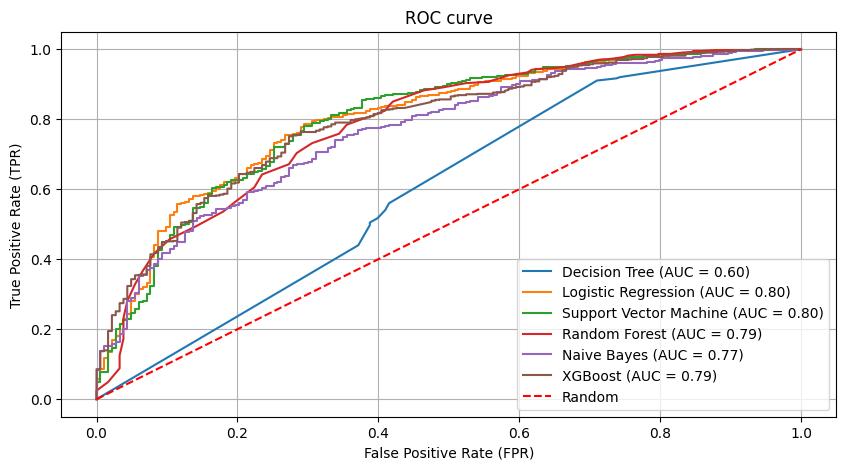

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

plt.figure(figsize=(10, 5))

for name, clf in classifiers.items():
    if hasattr(clf, "predict_proba"):
        y_scores = clf.predict_proba(X_val)[:, 1]
    else:
        y_scores = clf.decision_function(X_val)

    fpr, tpr, _ = roc_curve(y_val, y_scores)
    auc_value = roc_auc_score(y_val, y_scores)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_value:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.legend(loc='lower right')
plt.title('ROC curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.grid()
plt.show()


The Receiver Operating Characteristic (ROC) curve is a graphical representation of the performance of a binary classification model at various threshold settings. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) for different threshold values. Here's an explanation of the key components:

1. **True Positive Rate (TPR)**: This is also known as sensitivity or recall. It is the ratio of correctly predicted positive observations to all actual positives. TPR = TP / (TP + FN), where TP is True Positives and FN is False Negatives. TPR tells us how good the model is at predicting positive classes.

2. **False Positive Rate (FPR)**: This is the ratio of incorrectly predicted negative observations to all actual negatives. FPR = FP / (FP + TN), where FP is False Positives and TN is True Negatives. FPR tells us how often the model makes a mistake and predicts a positive outcome when the actual outcome was negative.

3. **Random Guess Line**: The diagonal line from (0,0) to (1,1) represents the ROC curve for a random classifier. Points above this line represent good models, as they have better TPR than FPR.

4. **ROC Curve**: The ROC curve shows the trade-off between sensitivity (TPR) and specificity (1 - FPR) as the threshold for classifying positive instances is varied. A perfect classifier would have its curve passing through the top-left corner (TPR=1, FPR=0), indicating high TPR and low FPR.

5. **Area Under the Curve (AUC)**: The area under the ROC curve quantifies the overall performance of the model across all possible classification thresholds. A higher AUC value indicates a better model.

In summary, the ROC curve helps us visualize and assess the performance of a binary classification model, especially in terms of its ability to discriminate between positive and negative classes.